In [1]:
import math
from analysis_tools import *
import bokeh
from bokeh.plotting import *
output_notebook()
import matplotlib.pyplot as plt

Loading BokehJS ...

In [2]:
runs = runsFromFolder('data_and_control')

In [3]:
test = runs[3]
plot = figure(title="Run")
plot.line([t.time for t in test.data], [t.motorTemp for t in test.data])
show(plot)

In [4]:
findSpikes(test)

[1647]

In [5]:
keys = list(filter(lambda x: not '_' in x, dir(test.data[0])))

In [6]:
eqTime = 60

def equilibriumSection(run, cutoffIndex):
    i = cutoffIndex
    cutoffTime = run.data[i].time
    while i > 0 and (cutoffTime - eqTime) < run.data[i].time:
        i -= 1

    return run.data[i:cutoffIndex]

In [7]:
eqData = equilibriumSection(test, findSpikes(test)[0])

# TODO: get and plot equilibrium section for all spikes

In [8]:
for key in keys:
    p = figure(title=key)
    p.line([t.time for t in eqData], [getattr(t, key) for t in eqData])
    show(p)

In [9]:
#tmpD = test.data[i-100:i]
#for key in keys:
#    p = figure(title=key)
#    p.line([t.time for t in tmpD], [getattr(t, key) for t in tmpD])
#    show(p)

In [10]:
import seaborn as sns

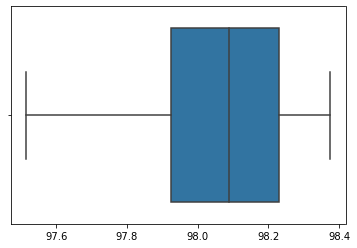

In [11]:
sns.boxplot([t.motorTemp for t in eqData])

In [12]:
from scipy import stats

In [13]:
times = [t.time for t in eqData]
temps = [t.motorTemp for t in eqData]
stats.linregress(times, temps)

LinregressResult(slope=-0.00228466252848583, intercept=100.53448402487585, rvalue=-0.21149961036661324, pvalue=0.07662997016381733, stderr=0.0012710145941406358)

In [14]:
import numpy

In [15]:
numpy.mean([t.motorTemp for t in eqData])

98.0675264084507

In [16]:
numpy.std([t.motorTemp for t in eqData])

0.18826494305427108

In [17]:
eqTests = list(filter(lambda x: 'EqTest' in x.file, runs))
[x.file for x in eqTests]

['EqTest_2019-09-23_134130.csv',
 'EqTest_2019-09-23_134330.csv',
 'EqTest_2019-09-23_135118.csv',
 'EqTest_2019-09-23_135154.csv',
 'EqTest_2019-09-23_135332.csv',
 'EqTest_2019-09-23_135501.csv',
 'EqTest_2019-09-24_112052.csv',
 'EqTest_2019-09-24_112139.csv',
 'EqTest_2019-09-24_112549.csv',
 'EqTest_2019-09-24_112643.csv',
 'EqTest_2019-09-24_112709.csv',
 'EqTest_2019-09-24_113349.csv',
 'EqTest_2019-09-24_113445.csv',
 'EqTest_2019-09-24_114905.csv',
 'EqTest_2019-09-24_114941.csv',
 'EqTest_2019-09-24_115021.csv',
 'EqTest_2019-09-24_115113.csv',
 'EqTest_2019-09-24_115656.csv',
 'EqTest_2019-09-24_172135.csv',
 'EqTest_2019-09-24_173459.csv',
 'EqTest_2019-09-25_175918.csv',
 'EqTest_2019-09-30_121817.csv',
 'EqTest_2019-09-30_123022.csv',
 'EqTest_2019-09-30_132931.csv',
 'EqTest_2019-09-30_132945.csv',
 'EqTest_2019-09-30_133004.csv',
 'EqTest_2019-09-30_133149.csv',
 'EqTest_2019-09-30_133156.csv',
 'EqTest_2019-09-30_133846.csv',
 'EqTest_2019-09-30_133909.csv',
 'EqTest_2

In [18]:

n = len(eqData)
n_2 = math.floor(n / 2)

mBar = 0
for i in range(0, n_2):
    x_i = eqData[i]
    x_ni = eqData[n_2 + i]
    m_i = (x_ni.motorTemp - x_i.motorTemp) / (x_ni.time - x_i.time)
    mBar += m_i
    
abs(mBar)

0.019029635007212352

In [19]:
def highlightSegment(run, hlStartTime, hlEndTime):
    hlStartIndex = -1
    hlEndIndex = -1

    i = 0
    while hlStartIndex < 0:
        if (test.data[i].time >= hlStartTime):
            hlStartIndex = i
        i += 1
    while hlEndIndex < 0:
        if (test.data[i].time >= hlEndTime):
            hlEndIndex = i
        i += 1

    plot = figure()

    plot.line([t.time for t in run.data], [t.motorTemp for t in run.data])
    hlData = run.data[hlStartIndex:hlEndIndex]
    plot.scatter([t.time for t in hlData], [t.motorTemp for t in hlData], line_color='orange')

    show(plot)

In [20]:
hlTimes = (eqData[0].time, eqData[-1].time)

highlightSegment(test, hlTimes[0], hlTimes[1])

In [21]:
class SlopeCutoff:
    def __init__(self):
        self.eqSize = 60 * 2
        self.sampleQueue = [(0.0, 0.0) for x in range(0, self.eqSize-1)]
        self.mQueue = [0 for x in range(0, math.floor((self.eqSize/2) - 1))]
        self.mSum = 0
        self.seen = 0
        self.mThresh = 1/self.eqSize

        self.record_mSum = list()

    def cutoffWindow(self, currentSample):
        self.seen += 1
    
        self.sampleQueue.pop(0)
        self.sampleQueue.append( (currentSample.time, currentSample.motorTemp) )
        self.mSum -= self.mQueue.pop(0)
                
        halfPt = self.sampleQueue[int((self.eqSize/2)-1)]
        yDelta = currentSample.motorTemp - halfPt[1]
        xDelta = currentSample.time - halfPt[0]
        m = yDelta / xDelta
        self.mQueue.append(m)
        self.mSum += m
    
        self.record_mSum.append( (currentSample.time, currentSample.motorTemp, self.mSum, m) )
    
        # If the queue is shorter than 60 seconds, keep running the motor.
        if self.seen < self.eqSize:
            return False
        else:
            return (abs(self.mSum) < self.mThresh) and (max([x[1] for x in self.sampleQueue]) - min([x[1] for x in self.sampleQueue])) < 1

In [22]:
#i = 0
#sc = SlopeCutoff()
#while i < len(test.data) and not sc.cutoffWindow(test.data[i]):
#    i += 1
#    
#i

In [23]:
#plot1 = figure()
#plot1.line([x.time for x in test.data], [x.motorTemp for x in test.data])
#show(plot1)

#plot2 = figure(x_range=plot1.x_range)
#plot2.line([x[0] for x in sc.record_mSum], [x[1] for x in sc.record_mSum])
#show(plot2)

In [24]:
#highlightSegment(test, sc.sampleQueue[0][0], sc.sampleQueue[-1:][0][0])

In [51]:
runsWithEqSpike = filter(lambda r: len(r.data) > 120 and max(r.data, key=lambda o: o.pwm).pwm > 1400, eqTests)

In [52]:
def findNewEqInRun(run):
    i = 0
    sc = SlopeCutoff()
    while i < len(run.data) and not sc.cutoffWindow(run.data[i]):
        i += 1

    highlightSegment(run, sc.sampleQueue[0][0], sc.sampleQueue[-1:][0][0])
    
    #plot = figure()
    #plot.scatter([x[0] for x in sc.record_mSum], [x[1] for x in sc.record_mSum])
    #show(plot)
    
    return sc

In [53]:
errs = list()
evaluation = list()
for run in runsWithEqSpike:
    print()
    print(run.file)
    try:
        sc = findNewEqInRun(run)
        temps = [x[1] for x in sc.sampleQueue]
        print('min temp: ' + str(min(temps)))
        print('max temp: ' + str(max(temps)))
        print('temp range: ' + str(max(temps) - min(temps)))
        print('samples: ' + str(len(sc.sampleQueue)))
        
        m_actual = stats.linregress([x[0] for x in sc.sampleQueue], [x[1] for x in sc.sampleQueue])
        
        evaluation.append(sc, m_actual)
        
    except:
        errs.append(run.file)


EqTest_2019-09-23_134130.csv


min temp: 74.21
max temp: 74.975
temp range: 0.7650000000000006
samples: 119

EqTest_2019-09-24_113445.csv


min temp: 78.485
max temp: 79.25
temp range: 0.7650000000000006
samples: 119

EqTest_2019-09-24_115656.csv


min temp: 78.125
max temp: 78.8
temp range: 0.6749999999999972
samples: 119

EqTest_2019-09-24_172135.csv


min temp: 85.4375
max temp: 85.8875
temp range: 0.45000000000000284
samples: 119

EqTest_2019-09-24_173459.csv


min temp: 82.5125
max temp: 82.9625
temp range: 0.45000000000000284
samples: 119

EqTest_2019-09-25_175918.csv


min temp: 83.525
max temp: 83.975
temp range: 0.44999999999998863
samples: 119

EqTest_2019-09-30_121817.csv


min temp: 98.7125
max temp: 101.4125
temp range: 2.6999999999999886
samples: 119

EqTest_2019-09-30_133004.csv


min temp: 75.2
max temp: 77.0
temp range: 1.7999999999999972
samples: 119

EqTest_2019-09-30_133156.csv


min temp: 78.4625
max temp: 87.125
temp range: 8.662499999999994
samples: 119

EqTest_2019-09-30_133909.csv

EqTest_2019-09-30_161348.csv


min temp: 92.975
max temp: 93.875
temp range: 0.9000000000000057
samples: 119

EqTest_2019-10-02_105302.csv


min temp: 71.375
max temp: 76.4375
temp range: 5.0625
samples: 119

EqTest_2019-10-02_105730.csv


min temp: 82.175
max temp: 82.85
temp range: 0.6749999999999972
samples: 119

EqTest_2019-10-04_114136.csv


min temp: 110.525
max temp: 124.925
temp range: 14.399999999999991
samples: 119

EqTest_2019-10-04_131417.csv


min temp: 83.975
max temp: 84.425
temp range: 0.45000000000000284
samples: 119

EqTest_2019-10-04_134902.csv


min temp: 82.7375
max temp: 83.1875
temp range: 0.45000000000000284
samples: 119

EqTest_2019-10-04_142226.csv


min temp: 87.35
max temp: 88.1375
temp range: 0.7875000000000085
samples: 119

EqTest_2019-10-04_144947.csv


min temp: 99.3875
max temp: 100.175
temp range: 0.7874999999999943
samples: 119

EqTest_2019-10-07_134108.csv


min temp: 84.425
max temp: 84.875
temp range: 0.45000000000000284
samples: 119

EqTest_2019-10-08_140011.csv


min temp: 86.225
max temp: 86.7875
temp range: 0.5625
samples: 119

EqTest_2019-10-08_143736.csv


min temp: 91.4
max temp: 92.3
temp range: 0.8999999999999915
samples: 119

EqTest_2019-10-14_110349.csv


min temp: 90.1625
max temp: 91.00625
temp range: 0.84375
samples: 119

EqTest_2019-10-14_123359.csv


min temp: 90.3875
max temp: 91.2875
temp range: 0.8999999999999915
samples: 119

EqTest_2019-10-14_134037.csv


min temp: 76.55
max temp: 76.8875
temp range: 0.3375000000000057
samples: 119

EqTest_2019-10-15_145812.csv


min temp: 73.625
max temp: 73.7375
temp range: 0.11249999999999716
samples: 119

EqTest_2019-10-15_160234.csv


min temp: 102.835625
max temp: 104.0
temp range: 1.1643750000000068
samples: 119

EqTest_2019-10-15_161852.csv


min temp: 92.4125
max temp: 93.3125
temp range: 0.9000000000000057
samples: 119

EqTest_2019-10-15_174235.csv


min temp: 74.075
max temp: 74.075
temp range: 0.0
samples: 119

EqTest_2019-10-15_174800.csv


min temp: 73.7375
max temp: 73.88375
temp range: 0.1462500000000091
samples: 119

EqTest_2019-10-16_101322.csv


min temp: 72.6125
max temp: 72.8375
temp range: 0.22500000000000853
samples: 119

EqTest_2019-10-16_102504.csv


min temp: 72.95
max temp: 72.95
temp range: 0.0
samples: 119

EqTest_2019-10-16_102819.csv


min temp: 72.95
max temp: 72.95
temp range: 0.0
samples: 119

EqTest_2019-10-16_103005.csv


min temp: 72.95
max temp: 72.95
temp range: 0.0
samples: 119

EqTest_2019-10-16_103716.csv


min temp: 90.3875
max temp: 91.175
temp range: 0.7874999999999943
samples: 119

EqTest_2019-10-17_222814.csv


min temp: 76.65125
max temp: 86.3375
temp range: 9.686250000000001
samples: 119

EqTest_2019-10-21_111713.csv


min temp: 89.7125
max temp: 90.275
temp range: 0.5625
samples: 119

EqTest_2019-10-21_160931.csv


min temp: 92.75
max temp: 93.65
temp range: 0.9000000000000057
samples: 119

EqTest_2019-10-21_163838.csv


min temp: 90.3875
max temp: 91.7375
temp range: 1.3499999999999943
samples: 119

EqTest_2019-10-21_174516.csv


min temp: 83.6375
max temp: 84.3125
temp range: 0.6749999999999972
samples: 119

EqTest_2019-10-21_182351.csv


min temp: 80.825
max temp: 81.3875
temp range: 0.5625
samples: 119

EqTest_2019-10-23_122712.csv


min temp: 75.2
max temp: 77.5625
temp range: 2.362499999999997
samples: 119

EqTest_2019-10-23_122952.csv


min temp: 77.1125
max temp: 78.0125
temp range: 0.9000000000000057
samples: 119

EqTest_2019-10-23_123214.csv


min temp: 78.125
max temp: 79.025
temp range: 0.9000000000000057
samples: 119


In [28]:
import seaborn as sns

## Toy Example of Slope Approximation

In [29]:
xtoy = [0,6,12,18,24,30,36,42,48,54]
ytoy = [79.6, 79.3,80.3, 79.7, 79.2, 79.5, 79.7, 79.9, 79.5, 79.6]

In [30]:
toyAvg = sum(ytoy) / len(ytoy)

In [31]:
toyReg = stats.linregress(xtoy, ytoy)

In [32]:
plot = figure(title='Time vs Temperature', x_axis_label='Time (s)', y_axis_label='Temperature (°F)', x_range=[-3,60])
plot.scatter(xtoy, ytoy, size=7)
plot.line(xtoy, ytoy, line_width=3)
show(plot)

In [33]:
cs = ['red', 'orange', 'green', 'blue', 'purple', 'grey']
pts = list(zip(xtoy, ytoy))

def line(p1, p2):
    return [p1, p2], (p2[1] - p1[1]) / (p2[0] - p1[0])

t = [ line(pts[0], pts[4]),
line(pts[1], pts[5]),
line(pts[2], pts[6]),
line(pts[3], pts[7]),
line(pts[4], pts[8]),
line(pts[5], pts[9]) ]

mbar = 0
for i in range(0, len(t)):
    l,m = t[i]
    plot.line([x[0] for x in l], [x[1] for x in l], line_color=cs[i], line_dash='dotted', line_width=2)
    mbar += m

show(plot)

In [34]:
toyReg.slope, mbar

(-0.00030303030303024275, -0.008333333333332865)

In [35]:
toyPlt = [(x, toyAvg+((x-30)*mbar)) for x in range(0, 60)]
xToyPlt = [x[0] for x in toyPlt]
yToyPlt = [x[1] for x in toyPlt]
plot.line(xToyPlt, yToyPlt, line_dash='dashed', line_color='red', line_width=3)
show(plot)

In [36]:
toyRegPlt = [(x, toyReg.intercept+(x*toyReg.slope)) for x in range(0, 60)]
xToyReg = [x[0] for x in toyRegPlt]
yToyReg = [x[1] for x in toyRegPlt]
plot.line(xToyReg, yToyReg, line_dash='dashed', line_color='black', line_width=5)
show(plot)

In [37]:
max(yToyPlt) - min(yToyPlt)

0.4916666666666458

In [38]:
mTest = 0
for i in range(0, len(xtoy)):
    for j in range(i+1, len(xtoy)):
        mTest += (ytoy[j] - ytoy[i]) / (xtoy[j] - ytoy[i])

mTest

0.00927036504749227

In [39]:
print('\n'.join([str(x[1]) for x in t]))

-0.016666666666666313
0.008333333333333451
-0.024999999999999762
0.008333333333333451
0.012499999999999881
0.00416666666666643


In [40]:
sum([x[1] for x in t])

-0.008333333333332865